In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gtsrb-german-traffic-sign/Meta.csv
/kaggle/input/gtsrb-german-traffic-sign/Train.csv
/kaggle/input/gtsrb-german-traffic-sign/Test.csv
/kaggle/input/gtsrb-german-traffic-sign/Meta/37.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/35.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/11.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/31.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/4.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/40.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/33.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/9.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/.~lock.ClassesInformation.ods#
/kaggle/input/gtsrb-german-traffic-sign/Meta/14.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/1.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/39.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/20.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/38.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/2.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/10.png


# # **Importing Libraries**

In [2]:
# Common
import numpy as np 
import pandas as pd 
import tensorflow as tf
import os

# Reading Images
import cv2
from PIL import Image

#Performance Plot
from sklearn import metrics 
from sklearn.metrics import f1_score, accuracy_score,confusion_matrix,classification_report
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# For the model and it's training
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.applications import VGG19

# Path & Randomness
import pathlib
import random as rn

# Time
import time
import datetime

# GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Style
from matplotlib import style
style.use('fivethirtyeight')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Num GPUs Available:  1


In [3]:
data_dir = '../input/gtsrb-german-traffic-sign'
train_path = '../input/gtsrb-german-traffic-sign/Train'
test_path = '../input/gtsrb-german-traffic-sign/'

# Resizing the images to 30x30x3
IMG_HEIGHT = 32
IMG_WIDTH = 32
channels = 3

In [4]:
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

# # **Labeling Catagories**

In [5]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

# # **Dataset Visualize**

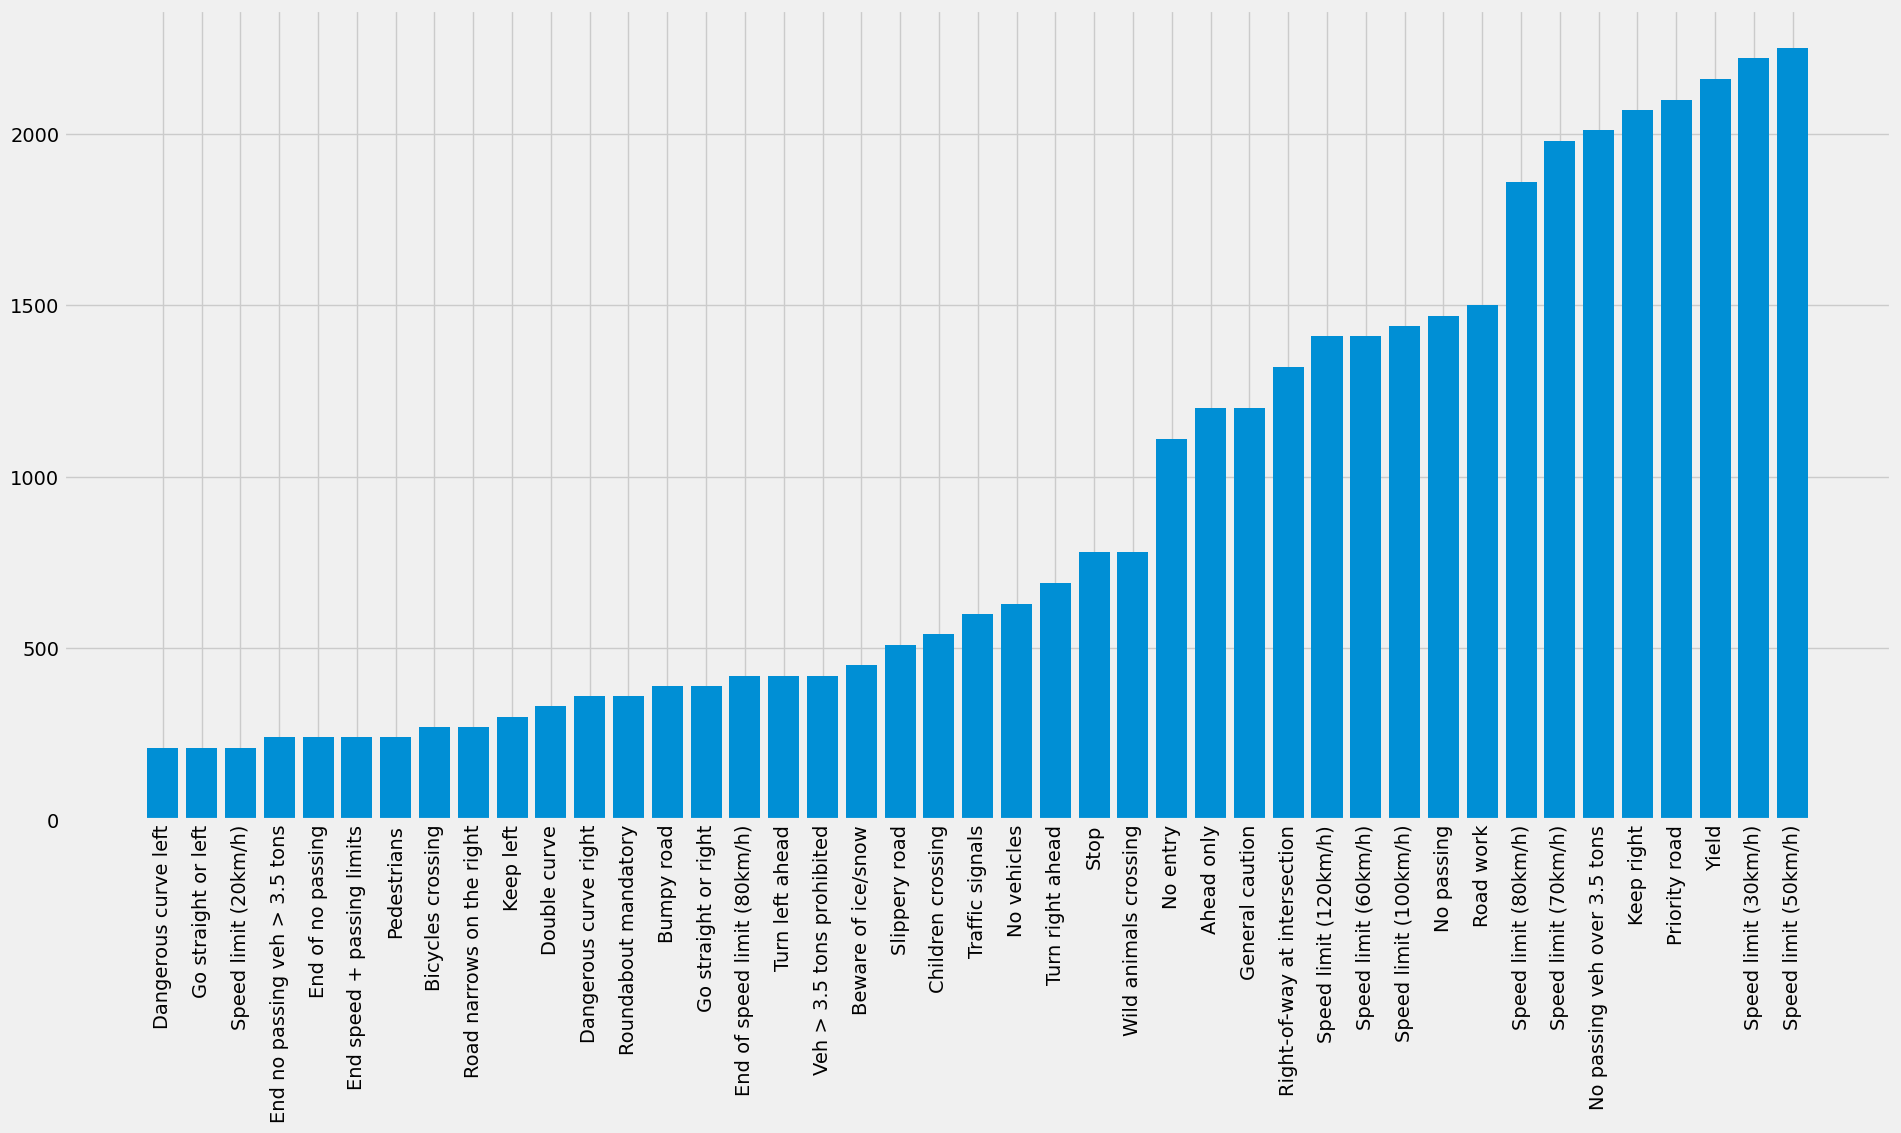

In [6]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

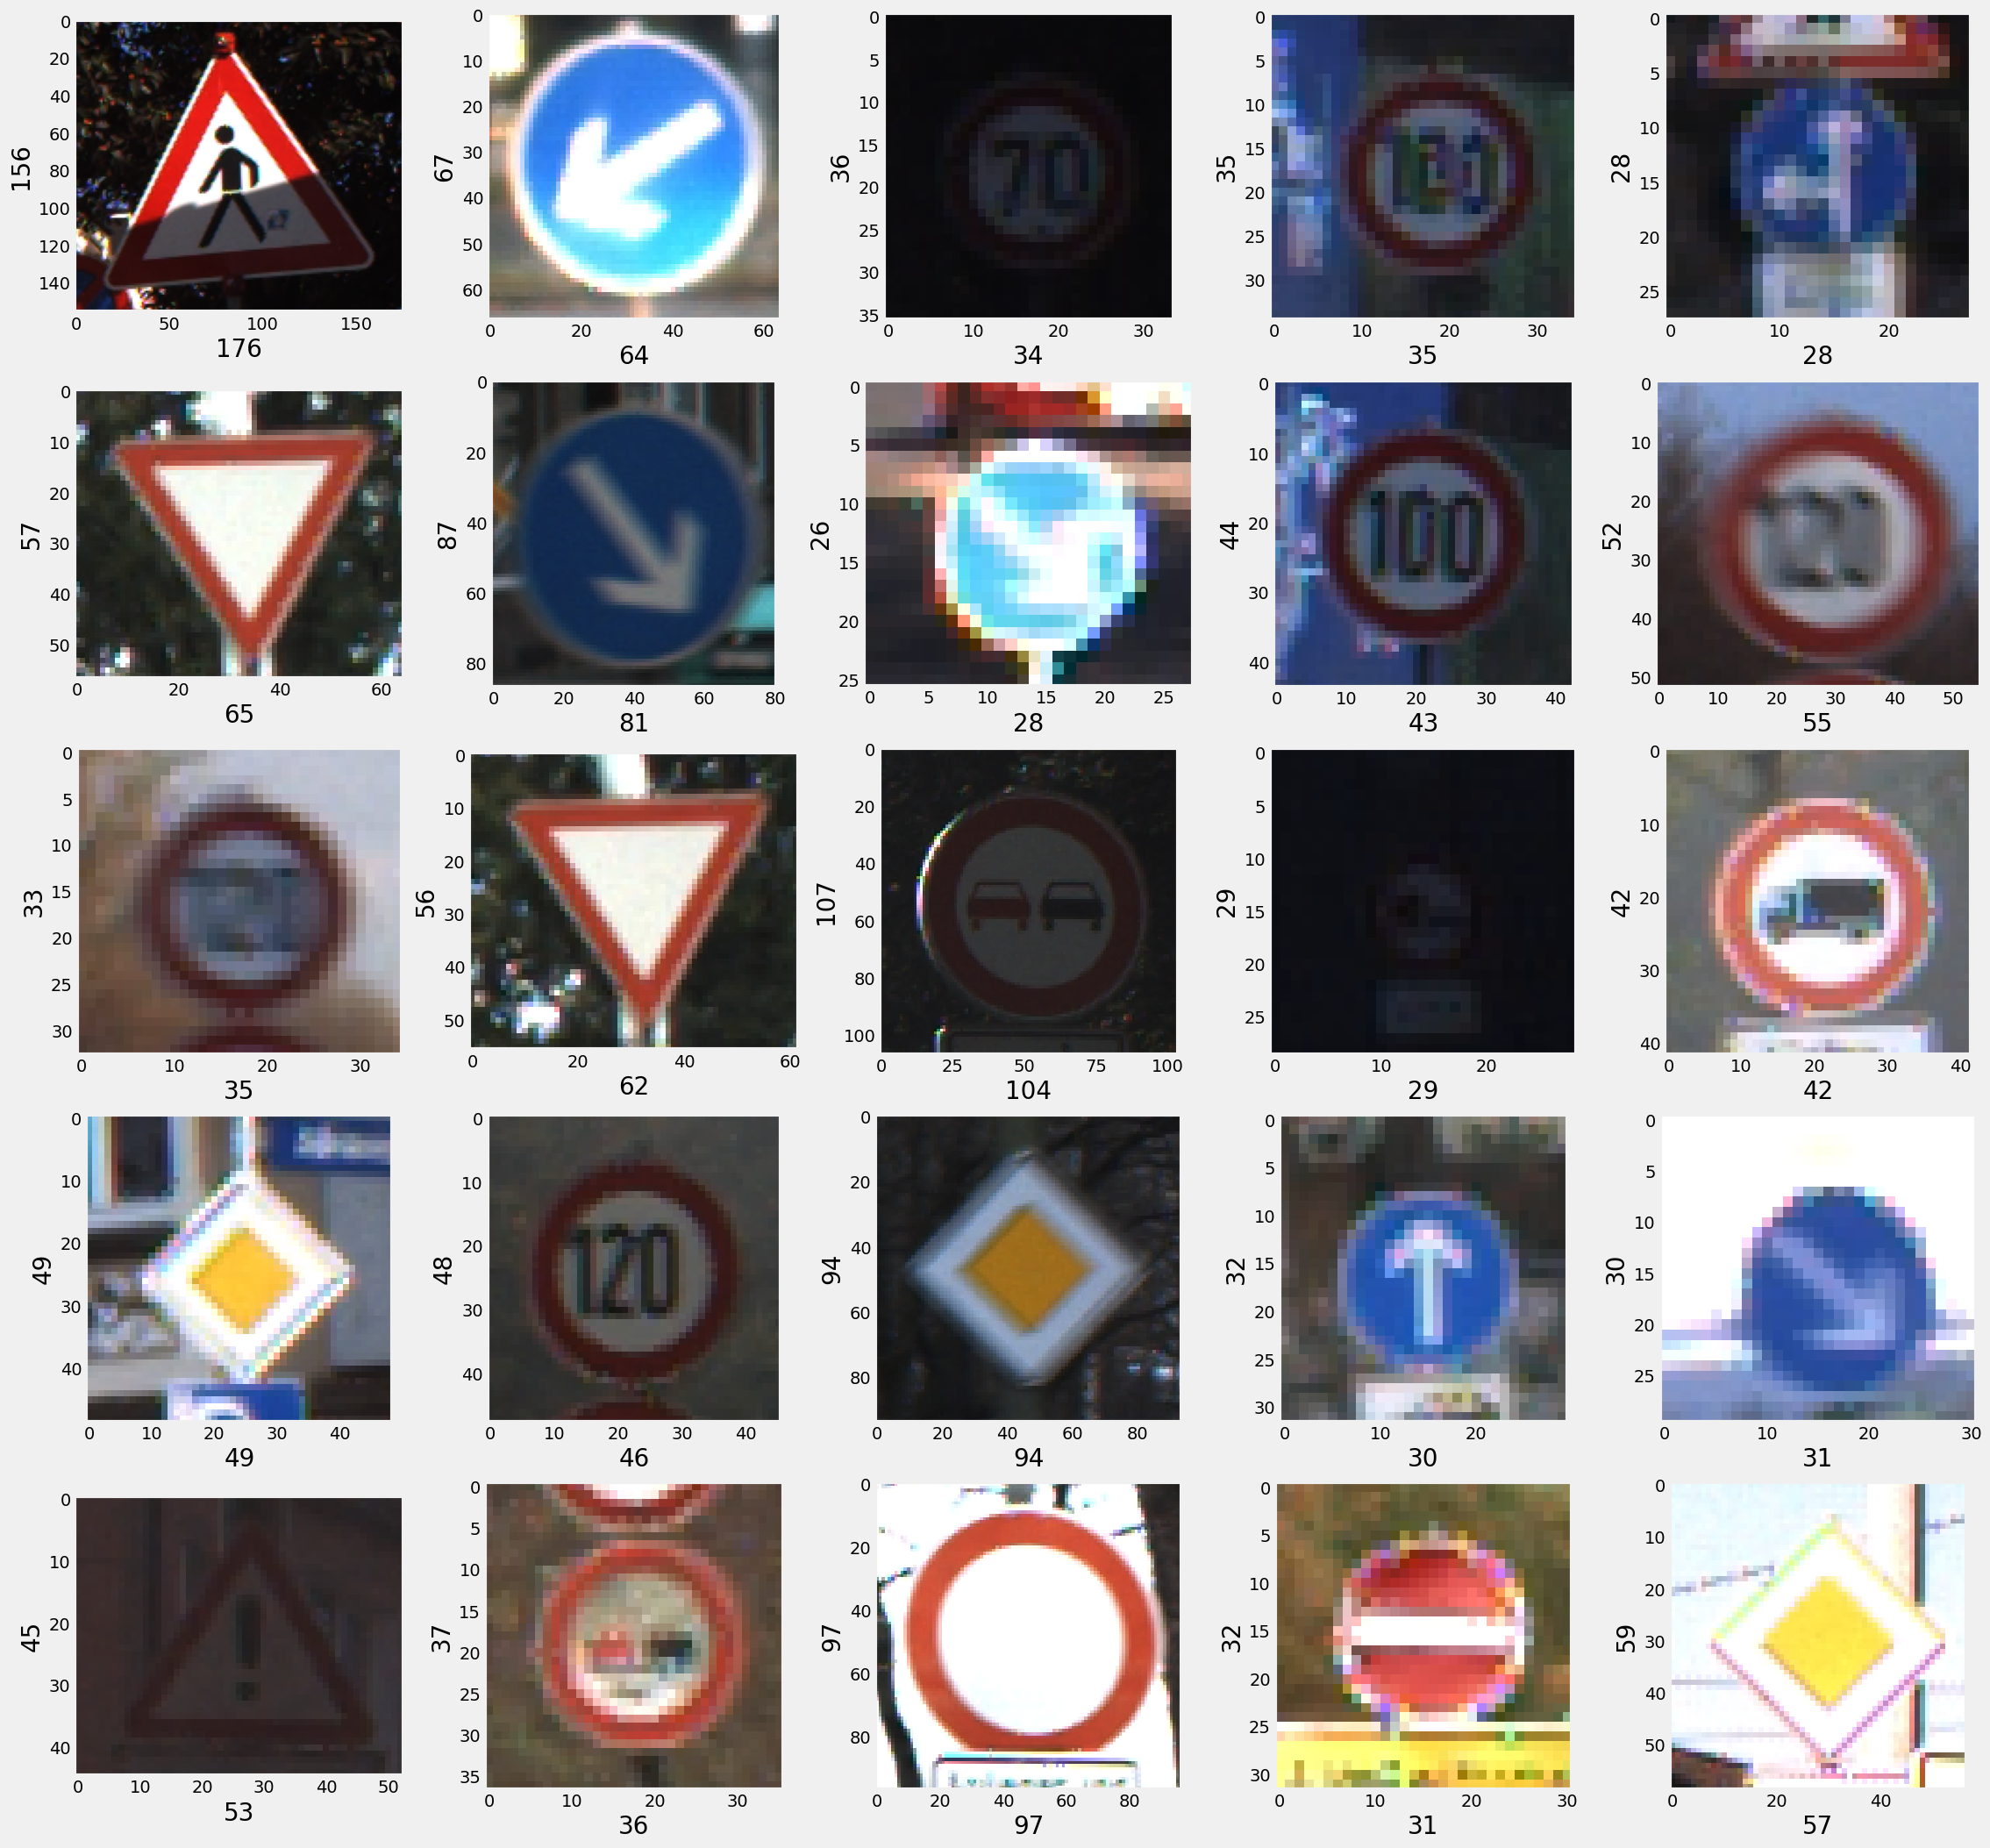

In [7]:
# Visualizing 25 random images from test data
import random
from matplotlib.image import imread

test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid() # b=None
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

# # **Collecting the Training Data**

In [8]:
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 32, 32, 3) (39209,)


# # **Shuffle Training Data**

In [9]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

# # **Splitting the data into train and validation set**

In [10]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255 
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 32, 32, 3)
X_valid.shape (11763, 32, 32, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


# # **One hot encoding the labels**

In [11]:
y_train = to_categorical(y_train, NUM_CATEGORIES)
y_val = to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


# # **Model Making**

In [12]:
model = Sequential([    
    Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    BatchNormalization(axis=-1),
    
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    BatchNormalization(axis=-1),
    
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(rate=0.5),
    
    Dense(43, activation='softmax')
])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 128)       7

In [14]:
LearningRate = 0.001
Epochs = 30

Optimizer = Adam(learning_rate=LearningRate, weight_decay=LearningRate / (Epochs * 0.5))
model.compile(loss='categorical_crossentropy', optimizer=Optimizer, metrics=['accuracy'])

# # **Augmenting the data and training the model**

In [15]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=Epochs, validation_data=(X_val, y_val))

Epoch 1/30
858/858 [==============================] - 31s 24ms/step - loss: 1.0940 - accuracy: 0.7037 - val_loss: 0.0883 - val_accuracy: 0.9739
Epoch 2/30
858/858 [==============================] - 20s 23ms/step - loss: 0.1791 - accuracy: 0.9437 - val_loss: 0.0933 - val_accuracy: 0.9792
Epoch 3/30
858/858 [==============================] - 19s 22ms/step - loss: 0.1152 - accuracy: 0.9644 - val_loss: 0.0353 - val_accuracy: 0.9894
Epoch 4/30
858/858 [==============================] - 20s 23ms/step - loss: 0.0914 - accuracy: 0.9717 - val_loss: 0.0392 - val_accuracy: 0.9872
Epoch 5/30
858/858 [==============================] - 19s 22ms/step - loss: 0.0786 - accuracy: 0.9757 - val_loss: 0.0160 - val_accuracy: 0.9957
Epoch 6/30
858/858 [==============================] - 20s 23ms/step - loss: 0.0719 - accuracy: 0.9780 - val_loss: 0.0242 - val_accuracy: 0.9934
Epoch 7/30
858/858 [==============================] - 20s 23ms/step - loss: 0.0704 - accuracy: 0.9781 - val_loss: 0.0136 - val_accuracy:

# # **Model Evaluation**

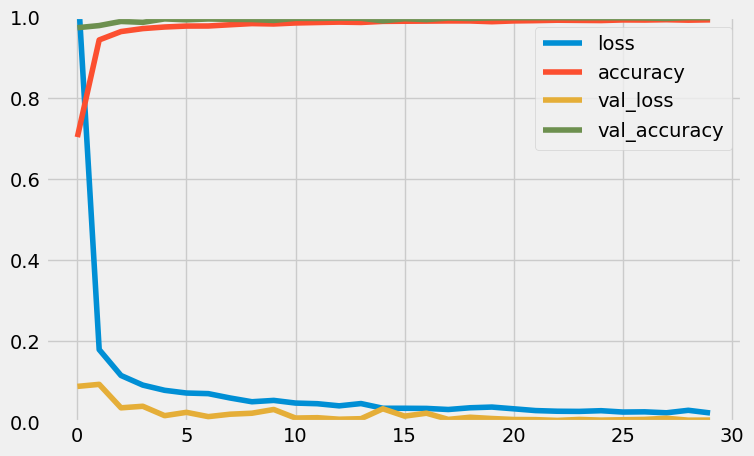

In [16]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

# # **Loading the test data and running the predictions**

In [17]:
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

pred = np.argmax(model.predict(X_test),axis=1)

#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

395/395 [==============================] - 1s 2ms/step
Test Data accuracy:  98.02850356294537


# **Visualizing the confusion matrix**

In [18]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(labels, pred)

<Axes: >

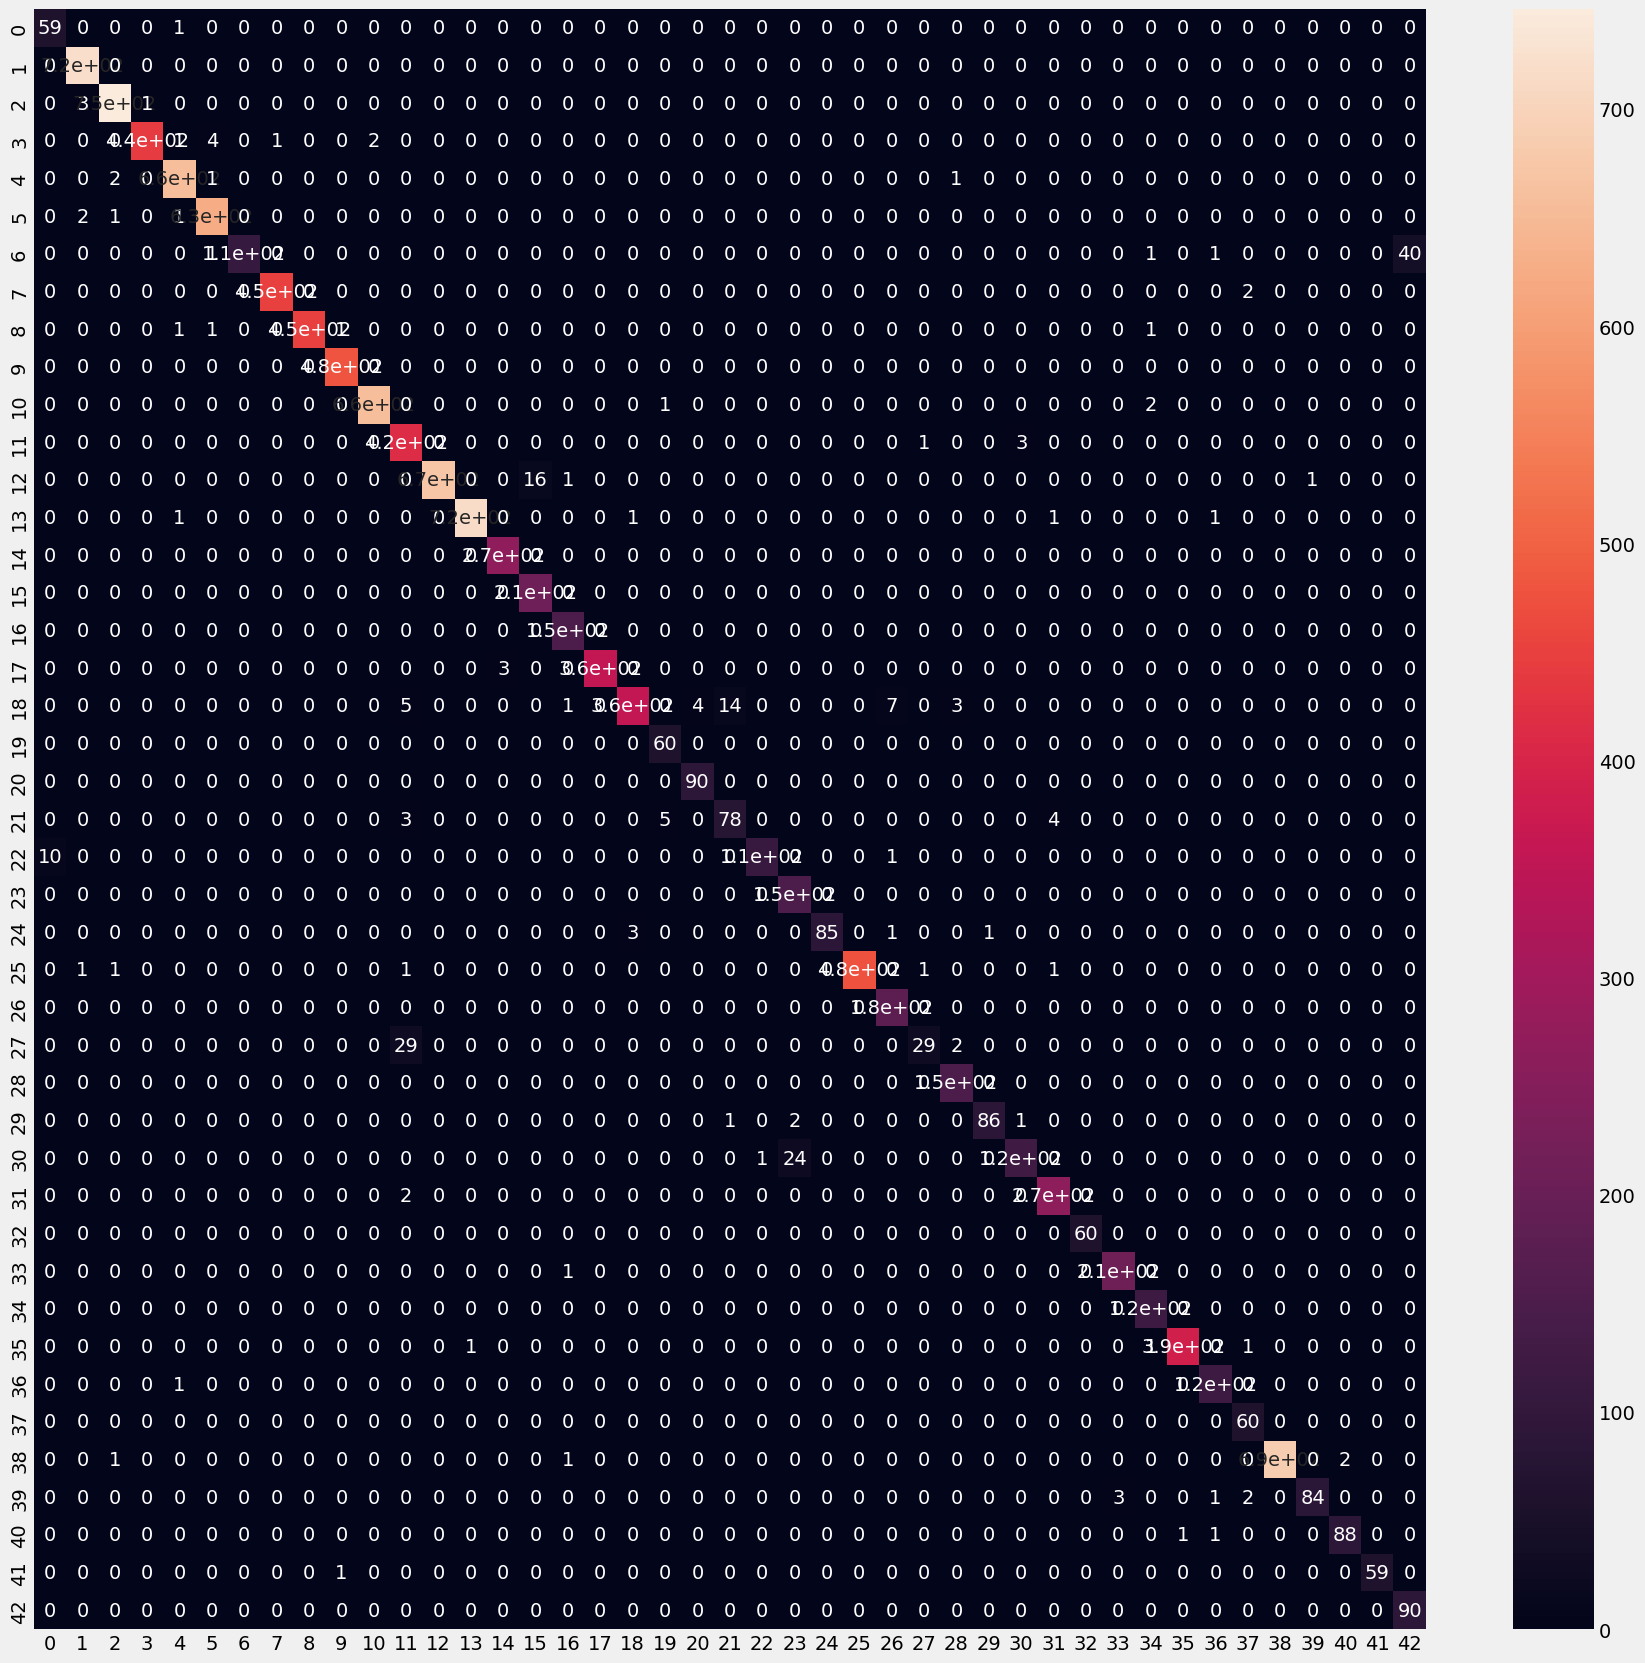

In [19]:
import seaborn as sns
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

# # **Classification report**

In [20]:
from sklearn.metrics import classification_report

print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       0.86      0.98      0.91        60
           1       0.99      1.00      1.00       720
           2       0.99      0.99      0.99       750
           3       1.00      0.98      0.99       450
           4       0.99      0.99      0.99       660
           5       0.99      0.99      0.99       630
           6       1.00      0.71      0.83       150
           7       1.00      1.00      1.00       450
           8       1.00      0.99      1.00       450
           9       1.00      1.00      1.00       480
          10       1.00      1.00      1.00       660
          11       0.91      0.99      0.95       420
          12       1.00      0.97      0.99       690
          13       1.00      0.99      1.00       720
          14       0.99      1.00      0.99       270
          15       0.93      1.00      0.96       210
          16       0.97      1.00      0.99       150
          17       1.00    

# # **Predictions on Test Data**

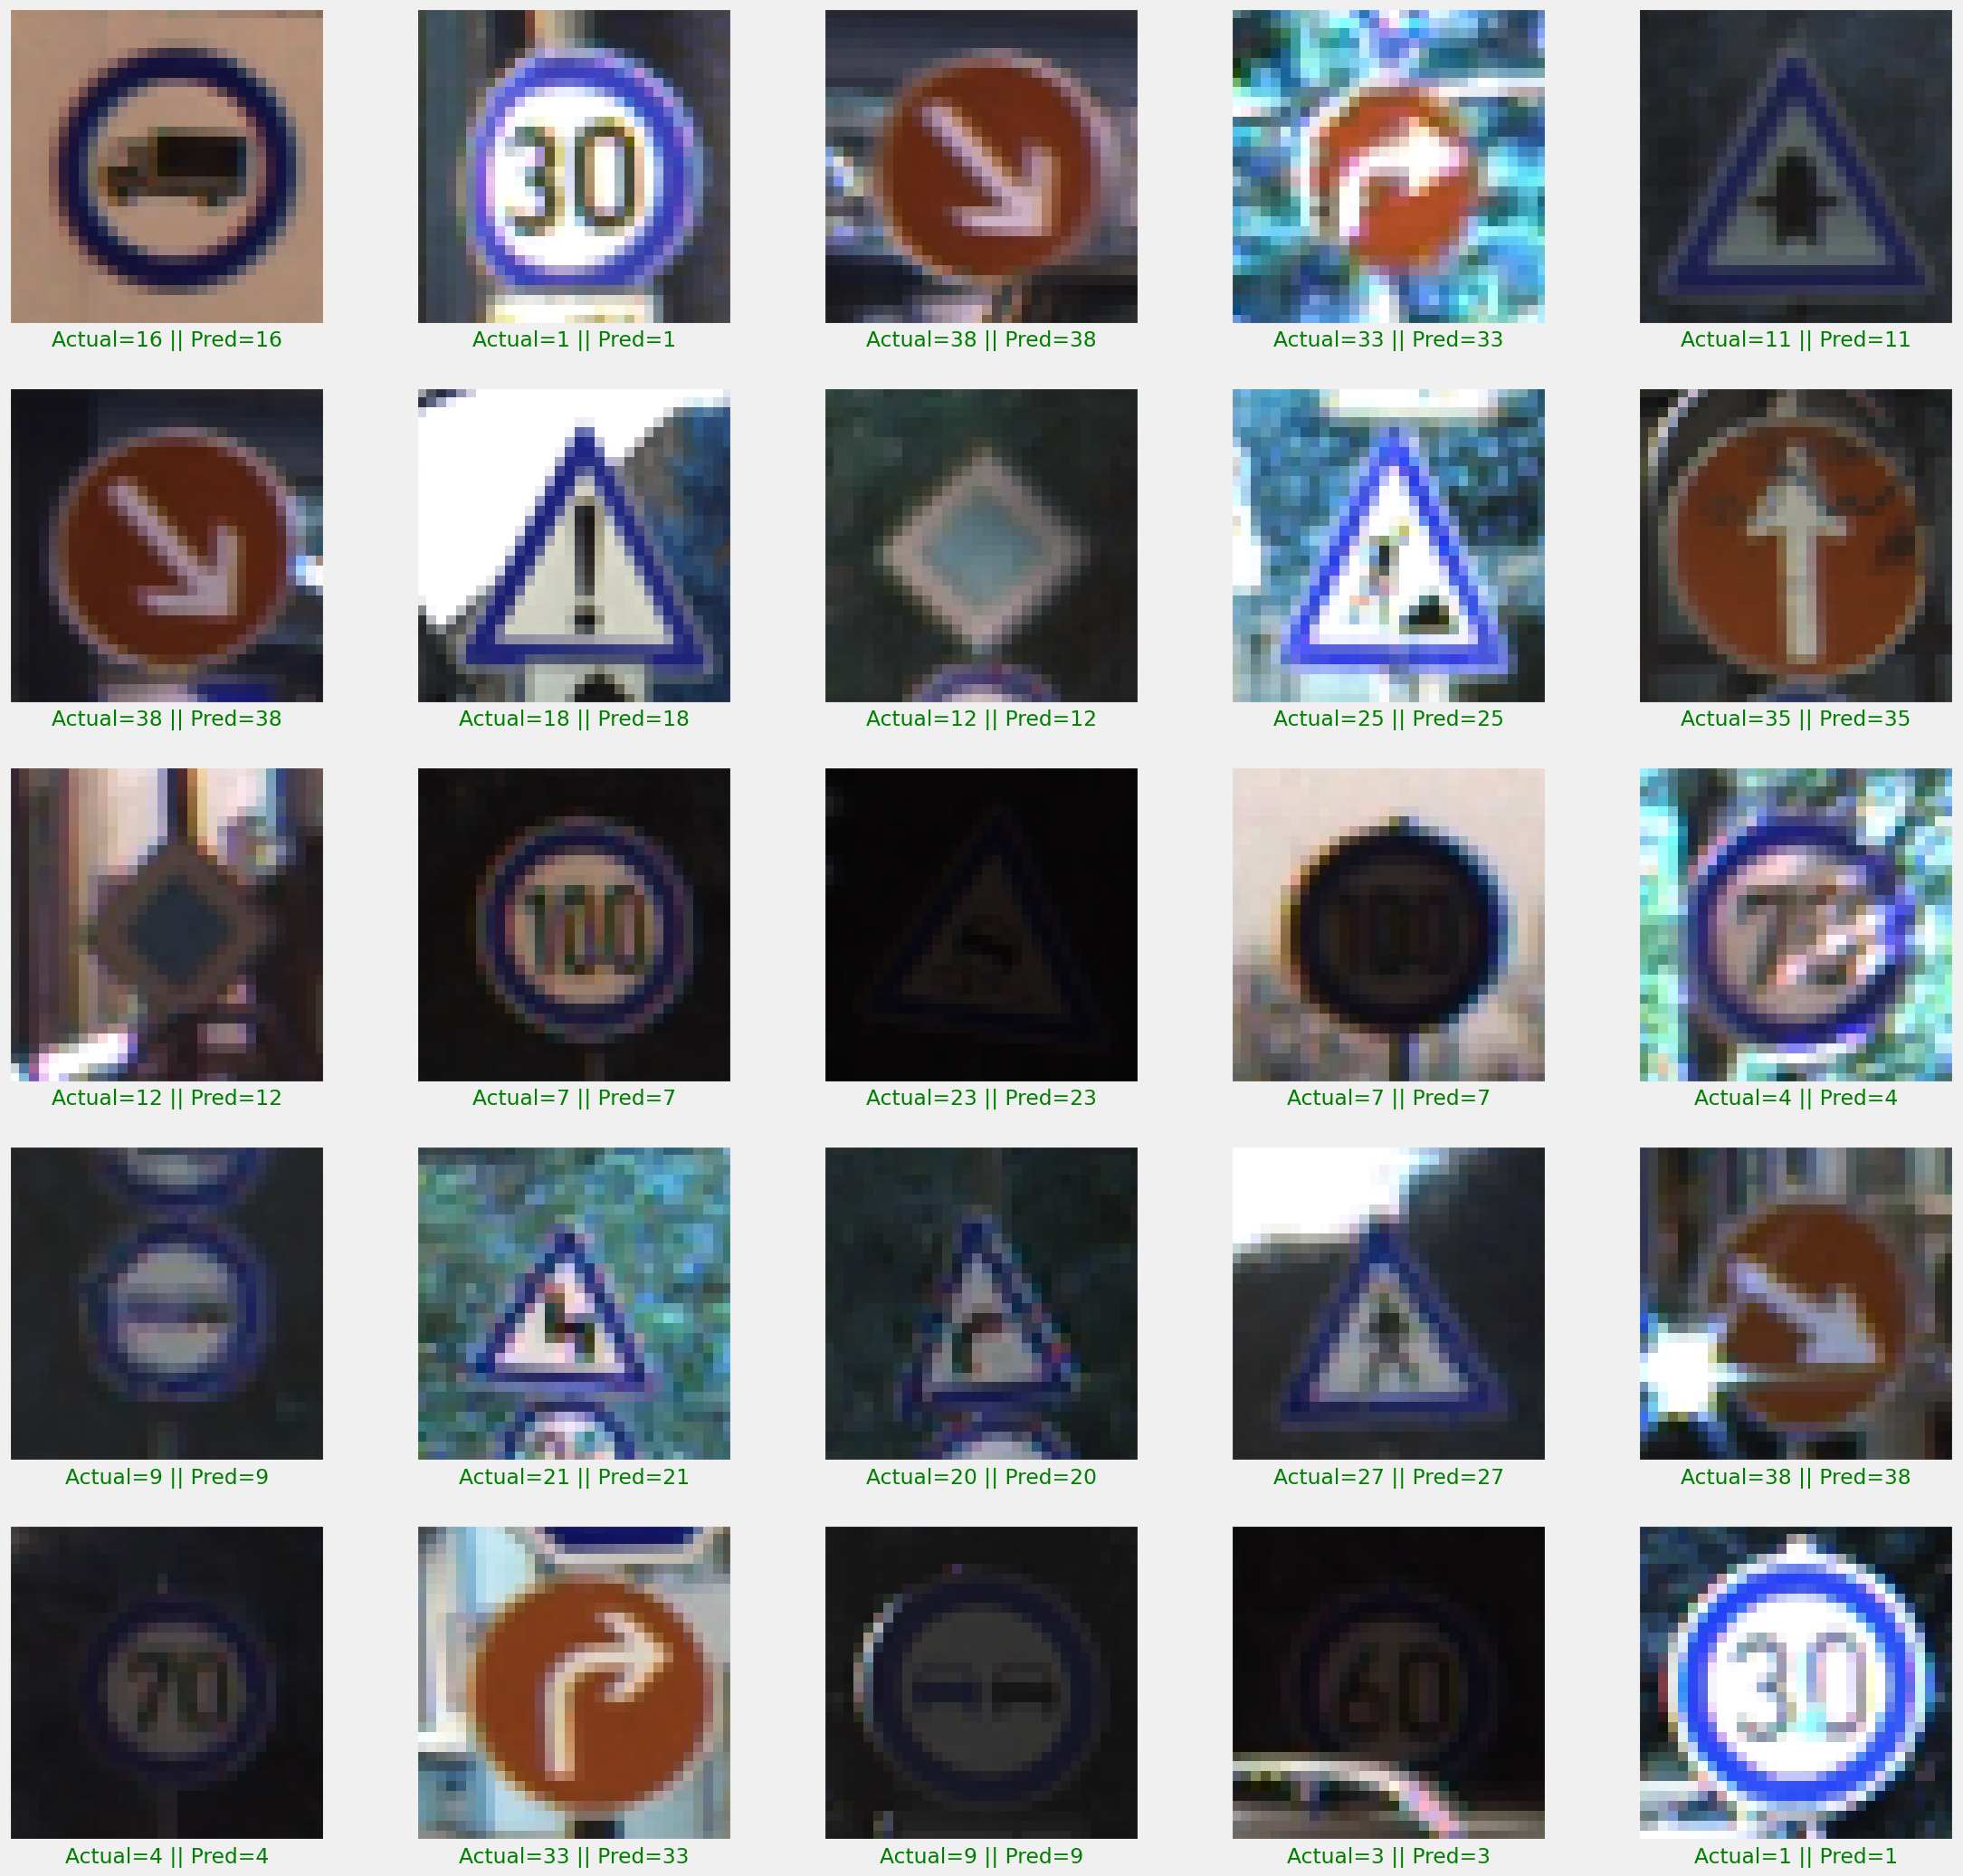

In [21]:
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()

## **Saving the Model**

In [22]:
# Saving the Model 
model.save('traffic_classifier_New.h5')

# **VGG Model**

### **Collecting the Trainning Data for VGG Model**

In [23]:
VGG_IMG_HEIGHT = 32
VGG_IMG_WIDTH = 32
VGG_channels = 3

In [24]:
image_data2 = []
image_labels2 = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((VGG_IMG_HEIGHT, VGG_IMG_WIDTH))
            image_data2.append(np.array(resize_image))
            image_labels2.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data2 = np.array(image_data2)
image_labels2 = np.array(image_labels2)

print(image_data2.shape, image_labels2.shape)

(39209, 32, 32, 3) (39209,)


### **Shuffle the Trainning data for VGG**

In [25]:
shuffle_indexes_New = np.arange(image_data2.shape[0])
np.random.shuffle(shuffle_indexes_New)
image_data2 = image_data2[shuffle_indexes_New]
image_labels2 = image_labels2[shuffle_indexes_New]

### **Again Use Test Train Split for VGG Model**

In [26]:
X_train_New, X_val_New, y_train_New, y_val_New = train_test_split(image_data2, image_labels2, test_size=0.3, random_state=42, shuffle=True)

X_train_New = X_train_New/255 
X_val_New = X_val_New/255

print("X_train.shape", X_train_New.shape)
print("X_valid.shape", X_val_New.shape)
print("y_train.shape", y_train_New.shape)
print("y_valid.shape", y_val_New.shape)

X_train.shape (27446, 32, 32, 3)
X_valid.shape (11763, 32, 32, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


### **One Hot Encoding the labels**

In [27]:
y_train_New = to_categorical(y_train_New, NUM_CATEGORIES)
y_val_New = to_categorical(y_val_New, NUM_CATEGORIES)

print(y_train_New.shape)
print(y_val_New.shape)

(27446, 43)
(11763, 43)


In [28]:
vgg_model = tf.keras.Sequential([VGG19(weights='imagenet', include_top=False, input_shape=(VGG_IMG_HEIGHT,VGG_IMG_WIDTH,VGG_channels)),
                                 BatchNormalization(),
                                 Flatten(),
                                 Dense(512, activation='sigmoid'),
                                 Dense(43, activation='softmax')
                                ])

vgg_model.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 batch_normalization_3 (Batc  (None, 1, 1, 512)        2048      
 hNormalization)                                                 
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dense_3 (Dense)             (None, 43)                22059     
                                                                 
Total params: 20,311,147
Trainable params: 20,310,123
N

In [29]:
VGG_LearningRate = 0.001
VGG_Epochs = 30

VGG_Optimizer = Adam(learning_rate=VGG_LearningRate, weight_decay=VGG_LearningRate / (VGG_Epochs * 0.5))
vgg_model.compile(loss='categorical_crossentropy', optimizer=VGG_Optimizer, metrics=['accuracy'])

# # **Augmenting the data and training the VGG Model**

In [30]:
AUG2 = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

VGG_history = vgg_model.fit(AUG2.flow(X_train_New, y_train_New, batch_size=32), epochs=VGG_Epochs, validation_data=(X_val_New, y_val_New))

Epoch 1/30
858/858 [==============================] - 35s 32ms/step - loss: 2.9298 - accuracy: 0.1418 - val_loss: 4.4513 - val_accuracy: 0.0817
Epoch 2/30
858/858 [==============================] - 26s 31ms/step - loss: 2.3534 - accuracy: 0.2515 - val_loss: 2.0266 - val_accuracy: 0.3021
Epoch 3/30
858/858 [==============================] - 27s 31ms/step - loss: 1.9838 - accuracy: 0.3320 - val_loss: 2.0586 - val_accuracy: 0.2842
Epoch 4/30
858/858 [==============================] - 29s 34ms/step - loss: 1.7535 - accuracy: 0.3965 - val_loss: 1.5783 - val_accuracy: 0.4231
Epoch 5/30
858/858 [==============================] - 26s 30ms/step - loss: 1.5278 - accuracy: 0.4722 - val_loss: 1.2268 - val_accuracy: 0.5739
Epoch 6/30
858/858 [==============================] - 29s 34ms/step - loss: 1.2897 - accuracy: 0.5576 - val_loss: 2.2271 - val_accuracy: 0.3565
Epoch 7/30
858/858 [==============================] - 26s 30ms/step - loss: 1.0611 - accuracy: 0.6339 - val_loss: 0.7189 - val_accuracy:

# # **Model Evaluation**

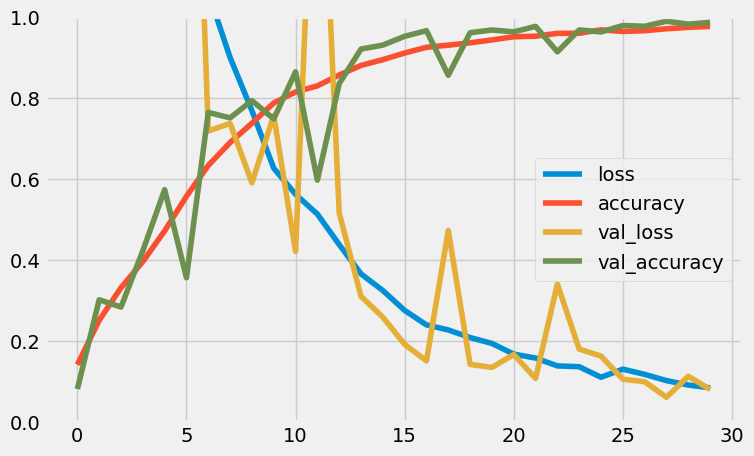

In [31]:
pd.DataFrame(VGG_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

# # **Loading the test data and running the predictions**

In [32]:
pred2 = np.argmax(vgg_model.predict(X_test),axis=1)

#Accuracy with the test data
print('Test Data accuracy for VGG Model: ',accuracy_score(labels, pred2)*100)

395/395 [==============================] - 3s 6ms/step
Test Data accuracy for VGG Model:  93.69754552652415


# **Visualizing the confusion matrix**

In [33]:
from sklearn.metrics import confusion_matrix
cf2 = confusion_matrix(labels, pred2)

<Axes: >

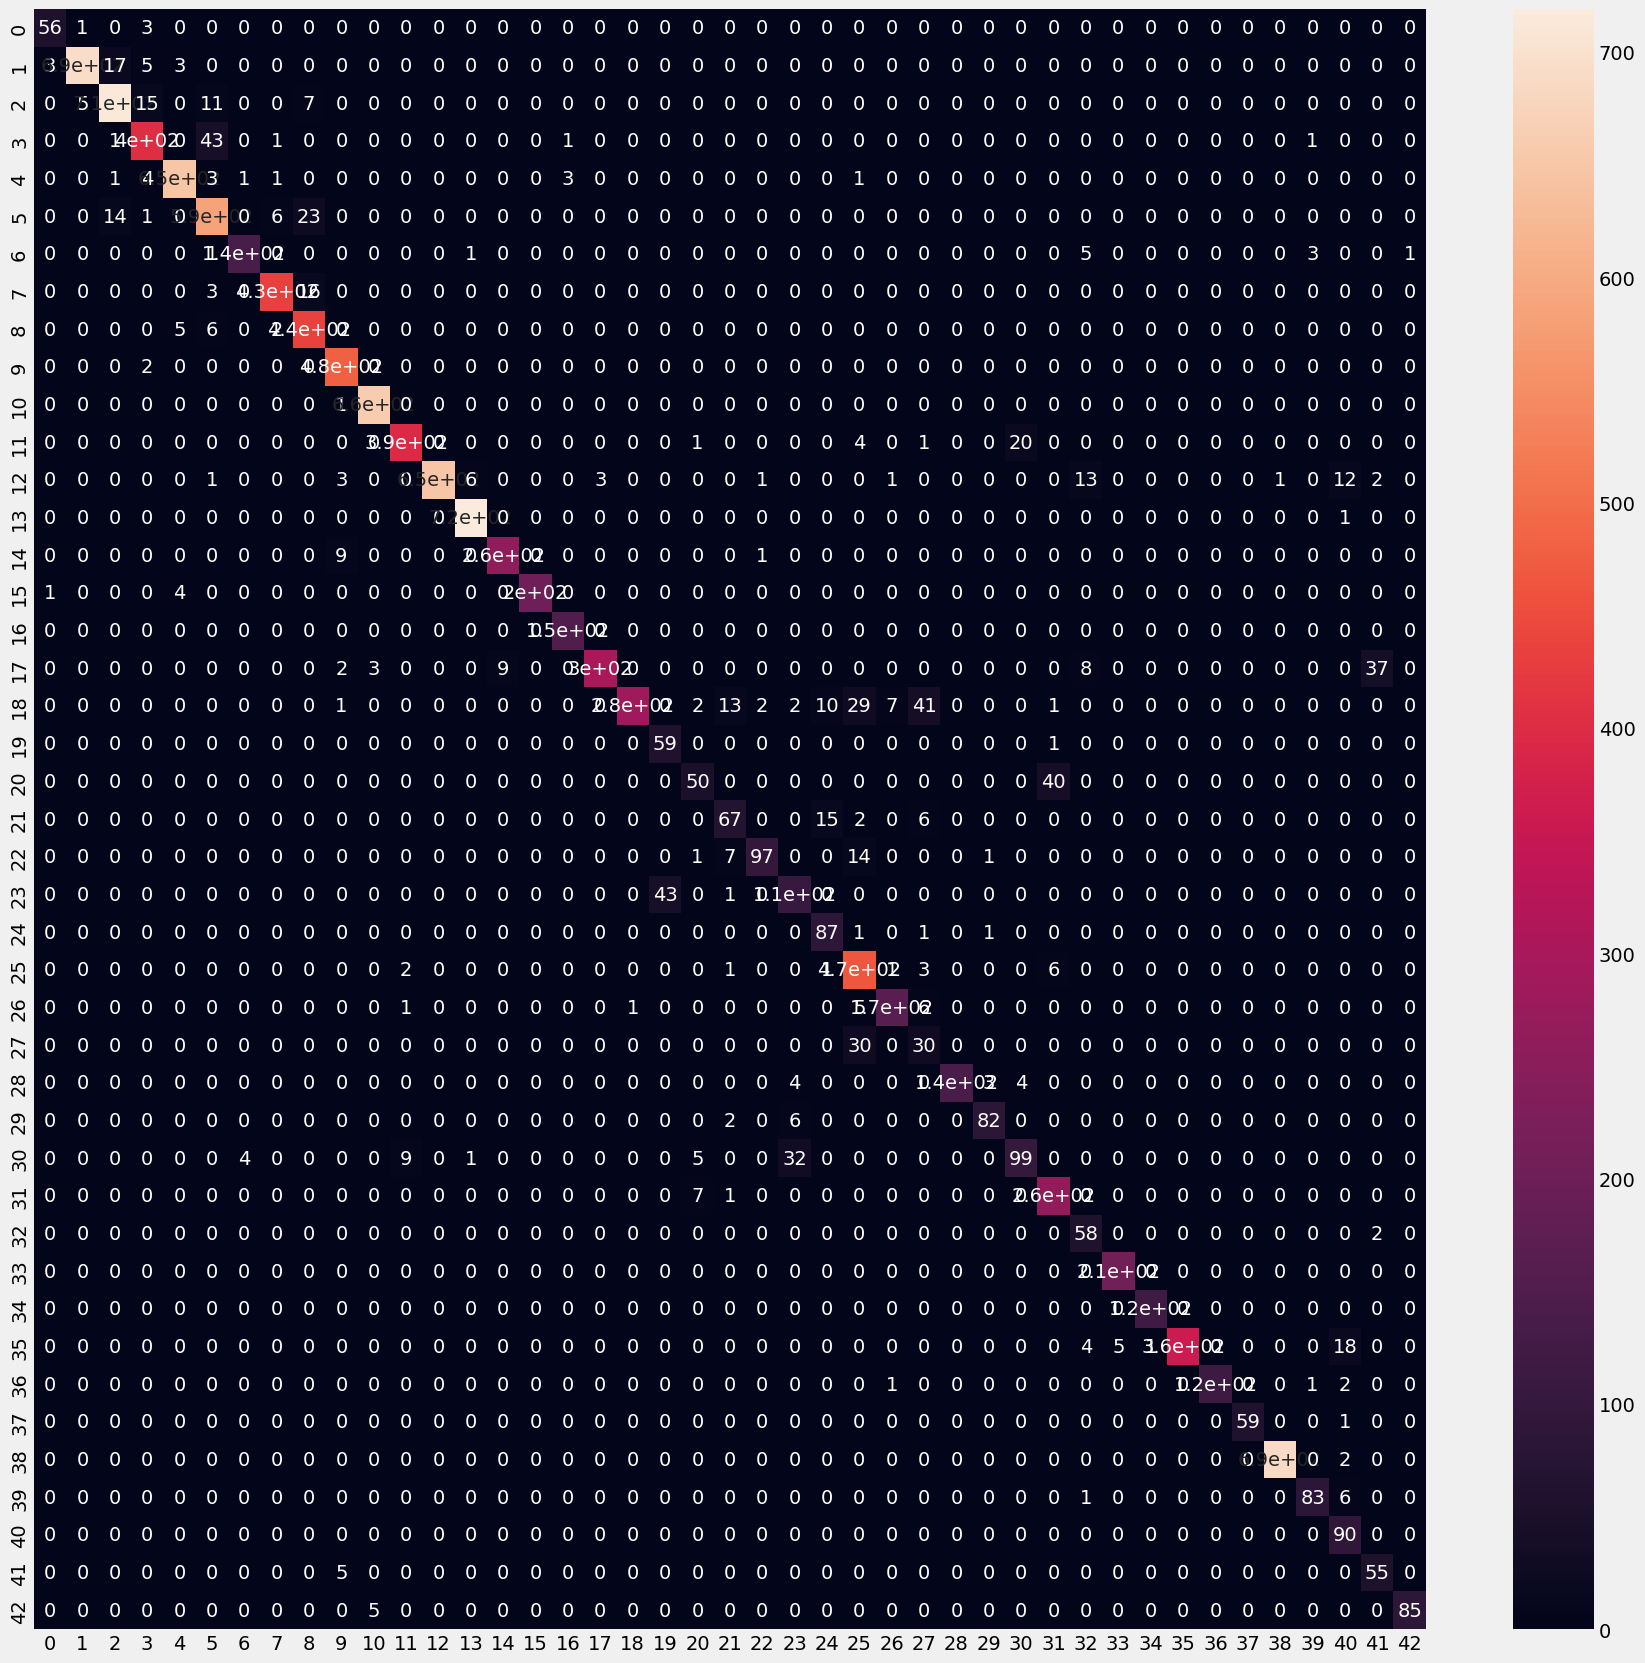

In [34]:
import seaborn as sns
df_cm_vgg = pd.DataFrame(cf2, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm_vgg, annot=True)

# # **Classification report**

In [35]:
from sklearn.metrics import classification_report

print(classification_report(labels, pred2))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        60
           1       0.99      0.96      0.98       720
           2       0.96      0.95      0.95       750
           3       0.93      0.90      0.91       450
           4       0.98      0.98      0.98       660
           5       0.90      0.93      0.91       630
           6       0.97      0.93      0.95       150
           7       0.98      0.96      0.97       450
           8       0.90      0.97      0.94       450
           9       0.96      1.00      0.98       480
          10       0.99      1.00      0.99       660
          11       0.97      0.94      0.95       420
          12       1.00      0.94      0.97       690
          13       0.99      1.00      0.99       720
          14       0.97      0.96      0.96       270
          15       1.00      0.98      0.99       210
          16       0.97      1.00      0.99       150
          17       0.99    

# # **Predictions on Test Data**

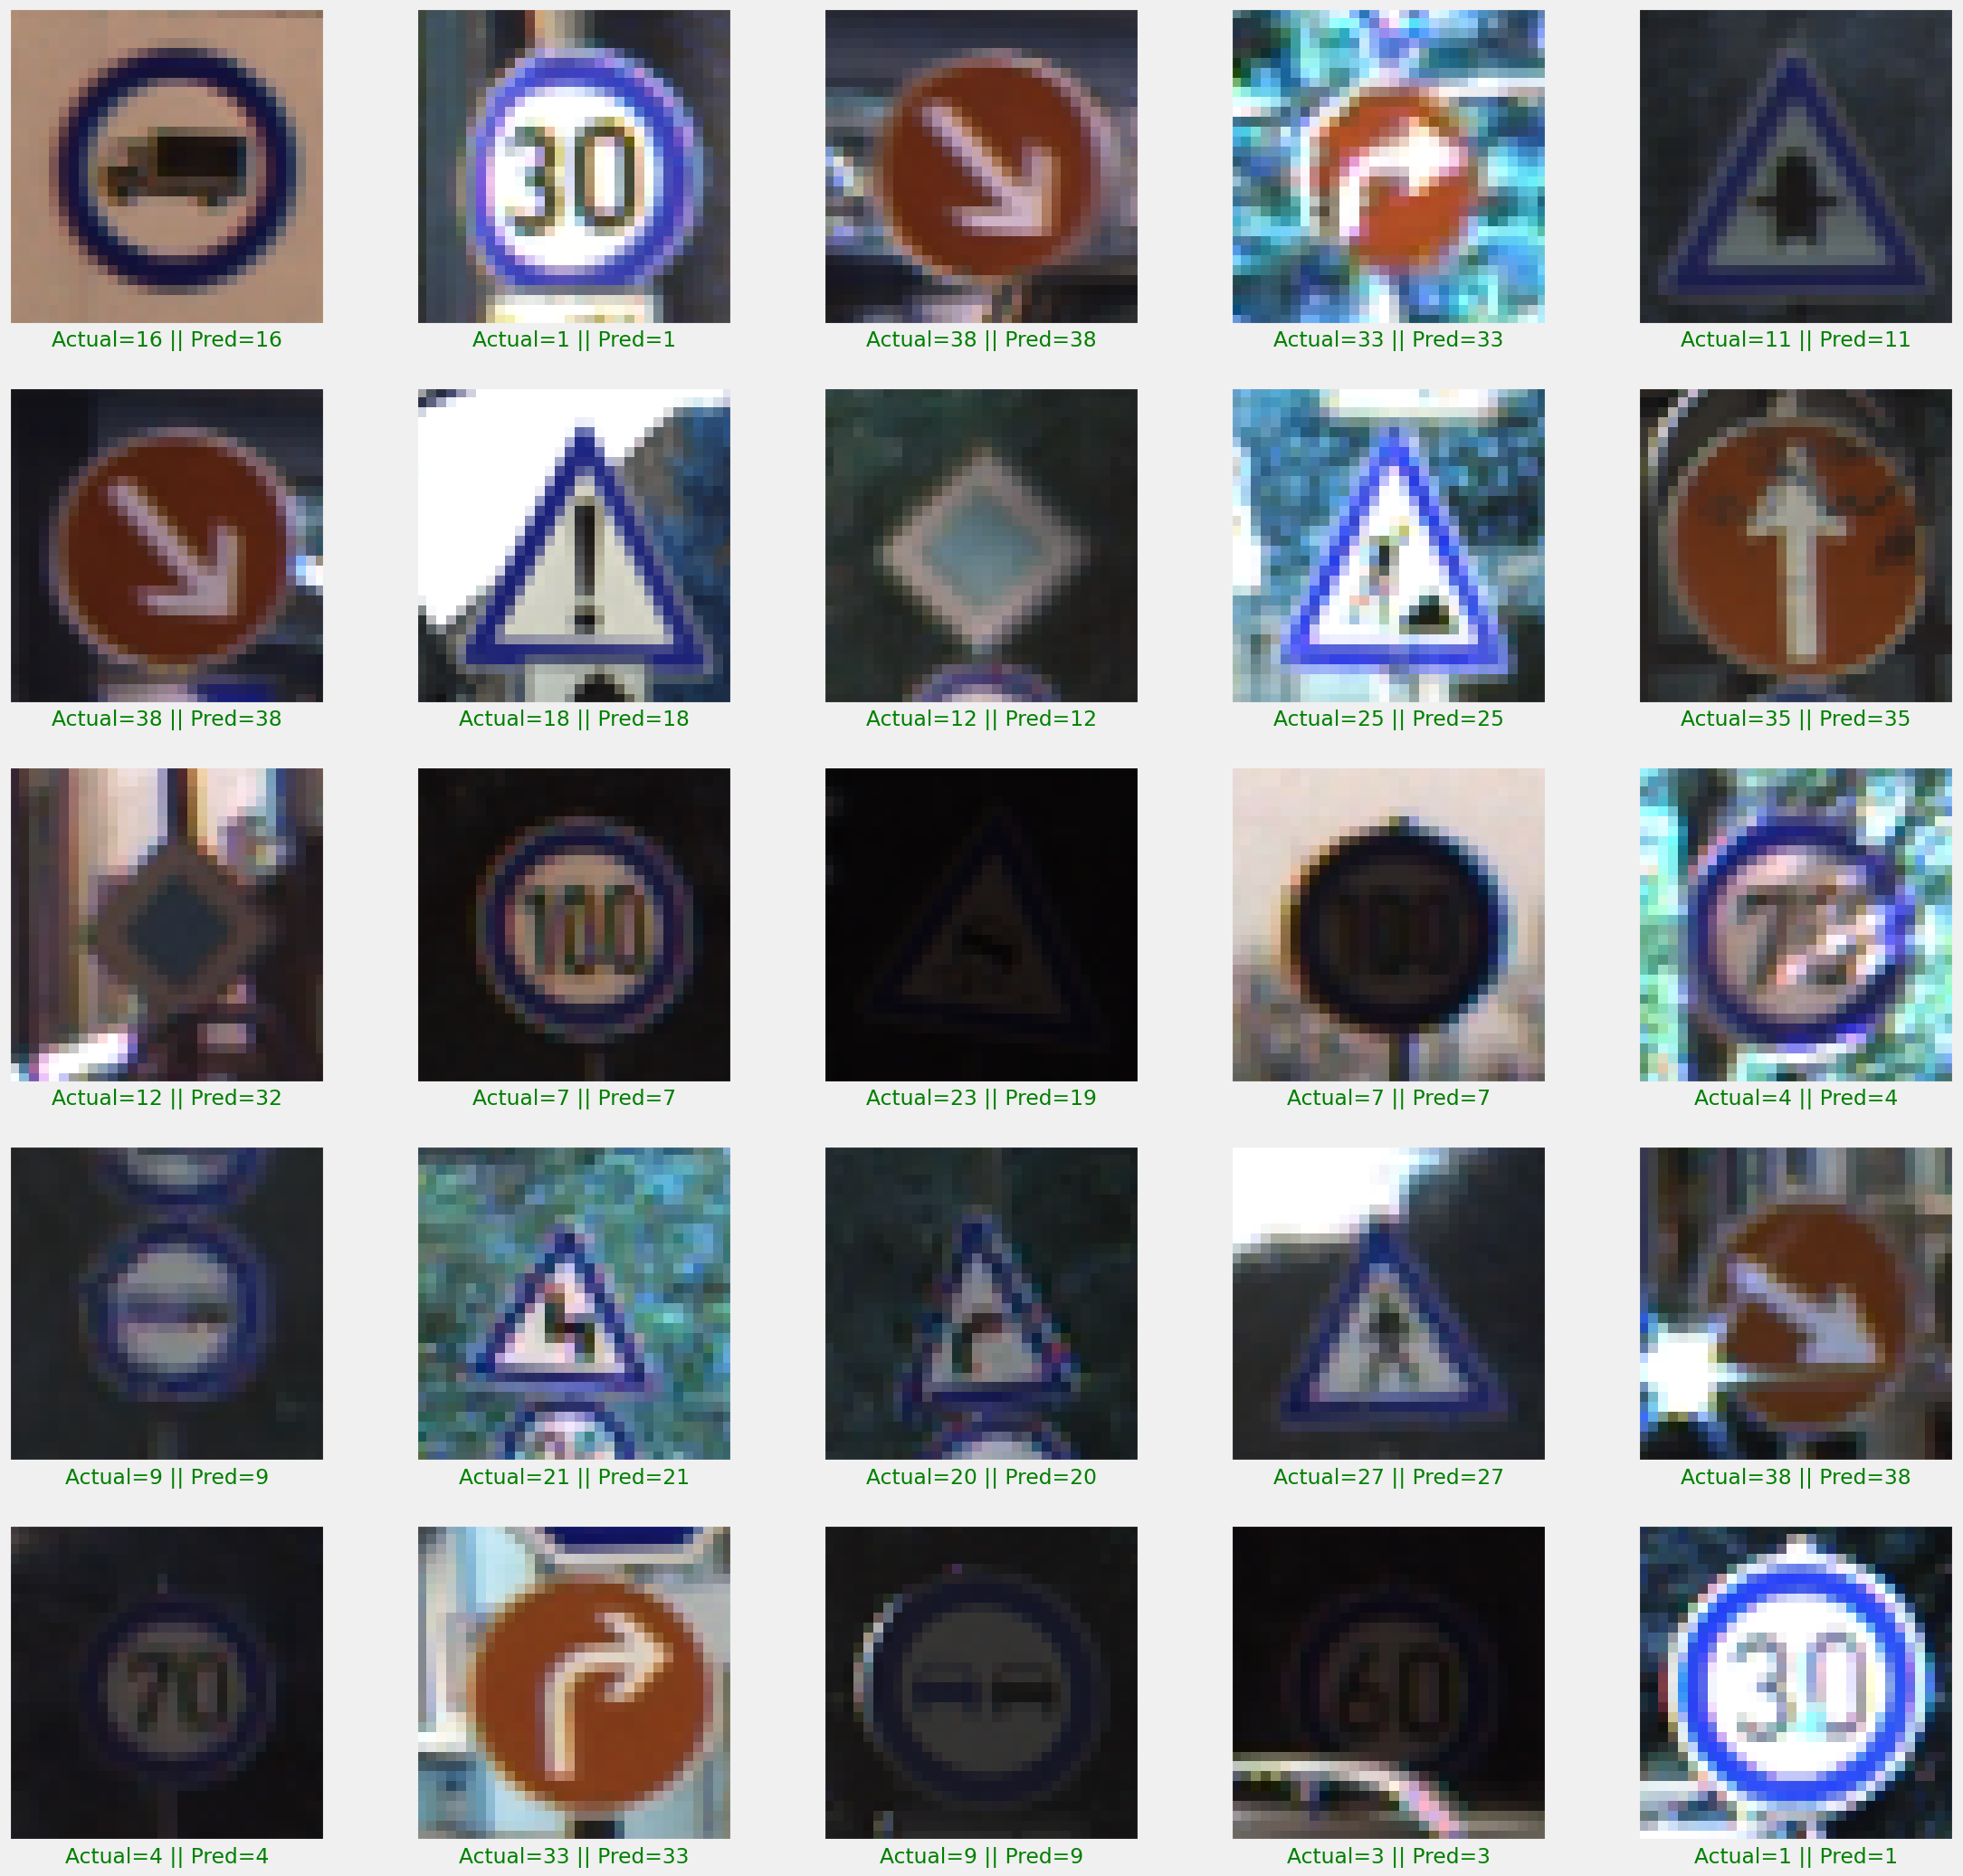

In [36]:
plt.figure(figsize = (25, 25))

start_index_vgg = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction2 = pred2[start_index_vgg + i]
    actual2 = labels[start_index_vgg + i]
    col2 = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual2, prediction2), color = col2)
    plt.imshow(X_test[start_index_vgg + i])
plt.show()

### **Save the VGG Model**

In [37]:
# Saving the Model 
vgg_model.save('traffic_classifier_vgg.h5')

### 